<a href="https://colab.research.google.com/github/SourLemon23/Eye-Net/blob/main/DeepStackEnsembleLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

! pip install tensorflow-addons


import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa

import tensorflow.keras.backend as K

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical

import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pandas as pd
import os
import importlib
import sys

! pip install deepstack
! pip install joblib
import joblib as joblib

Using TensorFlow Version: 2.5.0
     |████████████████████████████████| 686kB 4.1MB/s 


Need the following cell to correct a mistake in ensemble.py from DeepStack (https://github.com/jcborges/DeepStack)

In [ ]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fin = open(r'/usr/local/lib/python3.7/dist-packages/deepstack/ensemble.py', "rt")
#read file contents to string
data = fin.read()
#replace all occurrences of the required string
data = data.replace('from keras.utils import to_categorical', 'from tensorflow.keras.utils import to_categorical')
#close the input file
fin.close()
#open the input file in write mode
fin = open(r'/usr/local/lib/python3.7/dist-packages/deepstack/ensemble.py', "wt")
#overrite the input file with the resulting data
fin.write(data)
#close the file
fin.close()

from deepstack.base import KerasMember  # For a generic (i.e., Non-Keras Model) check the class `Member`
from deepstack.ensemble import StackEnsemble

In [ ]:
dataset_dir = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/cropped_APTOS_dataset'
labels = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/v2APTOSBinaryData.csv'

In [ ]:
train_data = pd.read_csv(labels, dtype = str)

In [ ]:
CLASSES = ['0 - No DR', '1 - DR']

CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 250, 250
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001 # default for Adam
MIN_DELTA = 1e-5
PATIENCE = 4
BATCH_SIZE = 32
EPOCHS = 5
VALIDATION_SPLIT = 0.15

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall'),
           CohenKappa(num_classes=2)]

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

In [ ]:
data_gen = ImageDataGenerator(validation_split=VALIDATION_SPLIT,
                              featurewise_center=True,
                              featurewise_std_normalization=True,
                              rescale=1./255,              # Simplify pixel values to be 0-1
                              horizontal_flip=True,        # Randomly flip images horizontally
                              zoom_range=0.1,              # Randomly zoom
                              shear_range=0.05,            # Shear angle in counter-clockwise direction
                              rotation_range=5,            # Randomly rotate
                              width_shift_range=0.03,      # Randomly shift the image left/right
                              height_shift_range=0.03,     # Randomly shift the image up/down
                              fill_mode='constant',        # Filling mode for points outside boundaries
                              cval=60,                     # Value used for points outside the boundaries
                              brightness_range=(0.9, 1.1)) # Randomly adjust the brightness
                            #  preprocessing_function for filters (if have time)

In [ ]:
training_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "training",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    validate_filenames=True)

validation_generator = data_gen.flow_from_dataframe(train_data, directory = dataset_dir,
                                                    subset = "validation",
                                                    x_col = "id_code", y_col = "diagnosis",
                                                    color_mode=COLOR_MODE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    validate_filenames=True)

Found 2900 validated image filenames belonging to 2 classes.
Found 511 validated image filenames belonging to 2 classes.


In [ ]:
model1 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/EfficientNet-B2')
member1 = KerasMember(name="EfficientNet-B2", keras_model=model1, train_batches=training_generator, val_batches=validation_generator)

model2 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/ResNet-50V2')
member2 = KerasMember(name="ResNet-50V2", keras_model=model2, train_batches=training_generator, val_batches=validation_generator)

model3 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/Xception')
member3 = KerasMember(name="Xception", keras_model=model3, train_batches=training_generator, val_batches=validation_generator)

model4 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/Inception-v3')
member4 = KerasMember(name="Inception-v3", keras_model=model4, train_batches=training_generator, val_batches=validation_generator)

model5 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/MobileNetV2')
member5 = KerasMember(name="MobileNetV2", keras_model=model5, train_batches=training_generator, val_batches=validation_generator)

model6 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/DenseNet-201')
member6 = KerasMember(name="DenseNet-201", keras_model=model6, train_batches=training_generator, val_batches=validation_generator)

model7 = load_model(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/VGG19')
member7 = KerasMember(name="VGG19", keras_model=model7, train_batches=training_generator, val_batches=validation_generator)

In [ ]:
ensemble_model = StackEnsemble()
ensemble_model.add_member(member1)
ensemble_model.add_member(member2)
# ensemble_model.add_member(member3)
# ensemble_model.add_member(member4)
ensemble_model.add_member(member5)
ensemble_model.add_member(member6)
# ensemble_model.add_member(member7)
ensemble_model.fit()
ensemble_model.describe()

Calling predict
EfficientNet-B2 - roc_auc_score: 0.9927
ResNet-50V2 - roc_auc_score: 0.9939
MobileNetV2 - roc_auc_score: 0.9949
DenseNet-201 - roc_auc_score: 0.9945
StackEnsemble roc_auc_score: 0.9948


0.9947765793528505

In [ ]:
model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v5'
ensemble_model.save(model_filepath)

<StackEnsemble: [EfficientNet-B2, ResNet-50V2, MobileNetV2, DenseNet-201]>

In [ ]:
ensemble_model1 = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v1')
ensemble_model2 = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v2')
ensemble_model3 = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v3')
ensemble_model4 = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v4')
ensemble_model5 = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v5')

Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201
Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201
Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201
Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201
Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201


In [ ]:
e_predictions1 = ensemble_model1._predict_val()
e_rounded_predictions1 = np.around(e_predictions1.copy()).astype(int)
print()

Calling predict



In [ ]:
e_predictions2 = ensemble_model2._predict_val()
e_rounded_predictions2 = np.around(e_predictions2.copy()).astype(int)

Calling predict


In [ ]:
e_predictions3 = ensemble_model._predict_val()
e_rounded_predictions3 = np.around(e_predictions3.copy()).astype(int)

Calling predict


In [ ]:
e_predictions4 = ensemble_model4._predict_val()
e_rounded_predictions4 = np.around(e_predictions4.copy()).astype(int)

Calling predict


In [ ]:
e_predictions5 = ensemble_model5._predict_val()
e_rounded_predictions5 = np.around(e_predictions5.copy()).astype(int)

Calling predict


In [ ]:
acc, prec, rec, f1 = get_metrics_for_stacks(e_rounded_predictions1, e_rounded_predictions2, e_rounded_predictions3, e_rounded_predictions4, e_rounded_predictions5)

In [ ]:
import sklearn
from sklearn.metrics import cohen_kappa_score

In [ ]:
cohen_kappa_score(e_rounded_predictions5, validation_generator.labels)

0.9528147988549971

In [ ]:
for i, metric in enumerate([acc, prec, rec, f1]):
    avg = "{:.4f}".format(np.mean(metric))
    std = "{:.10f}".format(np.std(metric))
    se = "{:.10f}".format(float(std) / (validation_generator.n) ** 0.5)
    print(str(i) + ': {} ± {}'.format(avg, se))

0: 0.9765 ± 0.0000000000
1: 0.9852 ± 0.0000000000
2: 0.9709 ± 0.0000000000
3: 0.9780 ± 0.0000000000


In [ ]:
def get_metrics_for_stacks(e1, e2, e3, e4, e5):
    acc = []
    prec = []
    rec = []
    f1 = []

    for i, preds in enumerate([e1, e2, e3, e4, e5]):
        false_positives = 0
        false_negatives = 0
        true_positives = 0
        true_negatives = 0

        for i in range(len(preds)):
          if (preds[i] != validation_generator.labels[i] and validation_generator.labels[i] == 0):
            false_positives+=1
          elif (preds[i] != validation_generator.labels[i] and validation_generator.labels[i] == 1):
            false_negatives+=1
          elif (preds[i] == validation_generator.labels[i] and validation_generator.labels[i] == 0):
            true_negatives+=1
          elif (preds[i] == validation_generator.labels[i] and validation_generator.labels[i] == 1):
            true_positives+=1

        # print('true_positives', true_positives)
        # print('true_negatives', true_negatives)
        # print('false_negatives', false_negatives)
        # print('false_positives', false_positives)
        
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_negatives + false_positives)
        f1_score = 2*precision*recall / (precision+recall)

        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        f1.append(f1_score)

    return acc, prec, rec, f1

    # print('accuracy', accuracy)
    # print('precision', precision)
    # print('recall', recall)
    # print('f1_score', f1_score)

In [ ]:
predictions1 = model1.predict(validation_generator,
                              verbose=1)
rounded_predictions1 = np.around(predictions1.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 101s 6s/step


In [ ]:
predictions2 = model2.predict(validation_generator,
                              verbose=1)
rounded_predictions2 = np.around(predictions2.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 128s 8s/step


In [ ]:
predictions3 = model3.predict(validation_generator,
                              verbose=1)
rounded_predictions3 = np.around(predictions3.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 158s 10s/step


In [ ]:
predictions4 = model4.predict(validation_generator,
                              verbose=1)
rounded_predictions4 = np.around(predictions4.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 108s 7s/step


In [ ]:
predictions5 = model5.predict(validation_generator,
                              verbose=1)
rounded_predictions5 = np.around(predictions5.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 71s 4s/step


In [ ]:
predictions6 = model6.predict(validation_generator,
                              verbose=1)
rounded_predictions6 = np.around(predictions6.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 183s 11s/step


In [ ]:
predictions7 = model7.predict(validation_generator,
                              verbose=1)
rounded_predictions7 = np.around(predictions7.copy()).astype(int)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 444s 27s/step


In [ ]:
def plot_roc_curve(data_generator, e_predictions, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6, predictions7, ax):
    ns_predictions = [0 for i in range(data_generator.n)]

    ns_auc = roc_auc_score(y_true=data_generator.labels, y_score=ns_predictions)
    e_auc = roc_auc_score(y_true=data_generator.labels, y_score=e_predictions)
    auc1 = roc_auc_score(y_true=data_generator.labels, y_score=predictions1)
    auc2 = roc_auc_score(y_true=data_generator.labels, y_score=predictions2)
    auc3 = roc_auc_score(y_true=data_generator.labels, y_score=predictions3)
    auc4 = roc_auc_score(y_true=data_generator.labels, y_score=predictions4)
    auc5 = roc_auc_score(y_true=data_generator.labels, y_score=predictions5)
    auc6 = roc_auc_score(y_true=data_generator.labels, y_score=predictions6)
    auc7 = roc_auc_score(y_true=data_generator.labels, y_score=predictions7)
    

    ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true=validation_generator.labels, y_score=ns_predictions)
    e_fpr, e_tpr, e_thresholds = roc_curve(y_true=validation_generator.labels, y_score=e_predictions)
    fpr1, tpr1, thresholds1 = roc_curve(y_true=validation_generator.labels, y_score=predictions1)
    fpr2, tpr2, thresholds2 = roc_curve(y_true=validation_generator.labels, y_score=predictions2)
    fpr3, tpr3, thresholds3 = roc_curve(y_true=validation_generator.labels, y_score=predictions3)
    fpr4, tpr4, thresholds4 = roc_curve(y_true=validation_generator.labels, y_score=predictions4)
    fpr5, tpr5, thresholds5 = roc_curve(y_true=validation_generator.labels, y_score=predictions5)
    fpr6, tpr6, thresholds6 = roc_curve(y_true=validation_generator.labels, y_score=predictions6)
    fpr7, tpr7, thresholds7 = roc_curve(y_true=validation_generator.labels, y_score=predictions7)

    ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.4f)' % ns_auc)
    ax.plot(e_fpr, e_tpr, marker='.', label='Ensemble Model (AUC = %0.4f)' % e_auc)
    ax.plot(fpr1, tpr1, marker='.', label=member1.name + ' (AUC = %0.4f)' % auc1)
    ax.plot(fpr2, tpr2, marker='.', label=member2.name + ' (AUC = %0.4f)' % auc2)
    ax.plot(fpr3, tpr3, marker='.', label=member3.name + ' (AUC = %0.4f)' % auc3)
    ax.plot(fpr4, tpr4, marker='.', label=member4.name + ' (AUC = %0.4f)' % auc4)    
    ax.plot(fpr5, tpr5, marker='.', label=member5.name + ' (AUC = %0.4f)' % auc5)
    ax.plot(fpr6, tpr6, marker='.', label=member6.name + ' (AUC = %0.4f)' % auc6)
    ax.plot(fpr7, tpr7, marker='.', label=member7.name + ' (AUC = %0.4f)' % auc7)

    ax.set_title('Receiver Operating Characteristic Curve', fontdict = {'family': 'DejaVu Sans',
                                                                        'color' : 'black',
                                                                        'weight': 'heavy',
                                                                        'size'  :  12})
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # so that legend doesn't overlap w/ NC curve
    ax.legend(loc=4, prop={'size': 9.5})
    # ax.legend()

In [ ]:
def plot_precision_recall(data_generator, e_predictions, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6, predictions7, ax):
    e_precision, e_recall, e_thresholds = precision_recall_curve(y_true=data_generator.labels, probas_pred=e_predictions)
    e_average_precision = average_precision_score(y_true=data_generator.labels, y_score=e_predictions)

    precision1, recall1, thresholds1 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions1)
    average_precision1 = average_precision_score(y_true=data_generator.labels, y_score=predictions1)

    precision2, recall2, thresholds2 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions2)
    average_precision2 = average_precision_score(y_true=data_generator.labels, y_score=predictions2)

    precision3, recall3, thresholds3 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions3)
    average_precision3 = average_precision_score(y_true=data_generator.labels, y_score=predictions3)

    precision4, recall4, thresholds4 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions4)
    average_precision4 = average_precision_score(y_true=data_generator.labels, y_score=predictions4)

    precision5, recall5, thresholds5 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions5)
    average_precision5 = average_precision_score(y_true=data_generator.labels, y_score=predictions5)

    precision6, recall6, thresholds6 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions6)
    average_precision6 = average_precision_score(y_true=data_generator.labels, y_score=predictions6)

    precision7, recall7, thresholds7 = precision_recall_curve(y_true=data_generator.labels, probas_pred=predictions7)
    average_precision7 = average_precision_score(y_true=data_generator.labels, y_score=predictions7)

    e_pr_display = PrecisionRecallDisplay(precision=e_precision, recall=e_recall, average_precision=e_average_precision, estimator_name=None)
    pr_display1 = PrecisionRecallDisplay(precision=precision1, recall=recall1, average_precision=average_precision1, estimator_name=None)
    pr_display2 = PrecisionRecallDisplay(precision=precision2, recall=recall2, average_precision=average_precision2, estimator_name=None)
    pr_display3 = PrecisionRecallDisplay(precision=precision3, recall=recall3, average_precision=average_precision3, estimator_name=None)
    pr_display4 = PrecisionRecallDisplay(precision=precision4, recall=recall4, average_precision=average_precision4, estimator_name=None)
    pr_display5 = PrecisionRecallDisplay(precision=precision5, recall=recall5, average_precision=average_precision5, estimator_name=None)
    pr_display6 = PrecisionRecallDisplay(precision=precision6, recall=recall6, average_precision=average_precision6, estimator_name=None)
    pr_display7 = PrecisionRecallDisplay(precision=precision7, recall=recall7, average_precision=average_precision7, estimator_name=None)
    
    e_pr_display.plot(ax=ax, name='Ensemble Model')
    pr_display1.plot(ax=ax, name=member1.name)
    pr_display2.plot(ax=ax, name=member2.name)
    pr_display3.plot(ax=ax, name=member3.name)
    pr_display4.plot(ax=ax, name=member4.name)
    pr_display5.plot(ax=ax, name=member5.name)
    pr_display6.plot(ax=ax, name=member6.name)
    pr_display7.plot(ax=ax, name=member7.name)

    L = plt.legend()
    L.get_texts()[0].set_text('Ensemble Model' + ' (AP = %0.4f)' % e_average_precision)
    L.get_texts()[1].set_text(member1.name + ' (AP = %0.4f)' % average_precision1)
    L.get_texts()[2].set_text(member2.name + ' (AP = %0.4f)' % average_precision2)
    L.get_texts()[3].set_text(member3.name + ' (AP = %0.4f)' % average_precision3)
    L.get_texts()[4].set_text(member4.name + ' (AP = %0.4f)' % average_precision4)
    L.get_texts()[5].set_text(member5.name + ' (AP = %0.4f)' % average_precision5)
    L.get_texts()[6].set_text(member6.name + ' (AP = %0.4f)' % average_precision6)
    L.get_texts()[7].set_text(member7.name + ' (AP = %0.4f)' % average_precision7)
    
    ax.set_title('Precision Recall Curve', fontdict = {'family': 'DejaVu Sans',
                                                       'color' : 'black',
                                                       'weight': 'heavy',
                                                       'size'  :  12})

In [ ]:
# not much a difference from ^, but might just look better and maybe easier to work with
# note that it has a weird font and style when plotting graphs, RUN THIS LAST..
def plot_heatmap_confusion_matrix(data_generator, predictions):
    cf = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
    
    df_cm = pd.DataFrame(cf, range(len(CLASSES)), range(len(CLASSES)))
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.0)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')
    # sns.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 16}, xticklabels=CLASSES, yticklabels=CLASSES, fmt='g')

    plt.xlabel('Predicted Labels', labelpad=20)
    plt.ylabel('Ground Truth Labels', labelpad=20)
    plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
                                              'color' : 'black',
                                              'weight': 'heavy',
                                              'size'  :  12})
    plt.show()

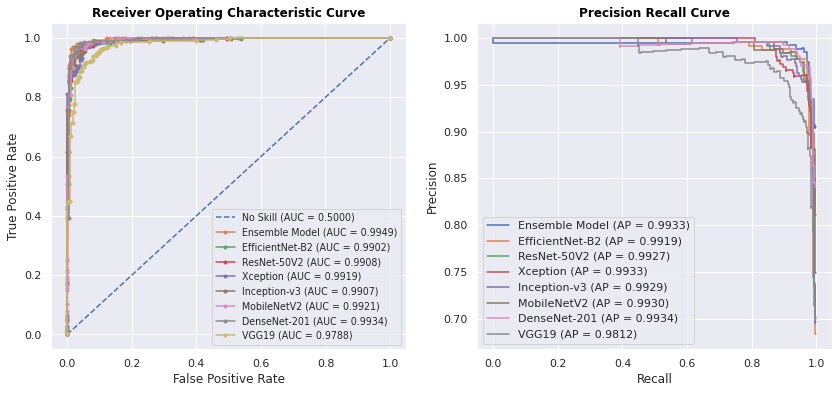

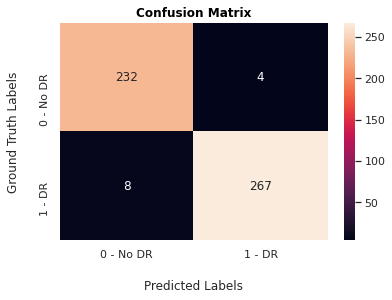

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

plot_roc_curve(validation_generator, e_predictions4, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6, predictions7, ax1)
plot_precision_recall(validation_generator, e_predictions4, predictions1, predictions2, predictions3, predictions4, predictions5, predictions6, predictions7, ax2)
plot_heatmap_confusion_matrix(validation_generator, e_rounded_predictions4)

In [ ]:
ensemble_model = StackEnsemble.load(r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/ensemble_models/4_Ensemble_Model_v4')
e_predictions = ensemble_model._predict_val()
e_rounded_predictions = np.around(e_predictions.copy()).astype(int)

Loaded EfficientNet-B2
Loaded ResNet-50V2
Loaded MobileNetV2
Loaded DenseNet-201
Calling predict


In [ ]:
print(classification_report(y_true=validation_generator.labels, y_pred=e_rounded_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       236
           1       0.99      0.97      0.98       275

    accuracy                           0.98       511
   macro avg       0.98      0.98      0.98       511
weighted avg       0.98      0.98      0.98       511

